In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import pokemon_gym
from pokemon_gym.pokemon import Pokemon
from pokemon_gym.qlearning import Qlearning_TDControl

### 4 types of Pokemons

In [3]:
allowed_types = ["normal", "fire", "water", "grass"]

effectiveness_chart = np.array([[1, 1, 1, 1],
                                [1, 1/2, 1/2, 2],
                                [1, 2, 1/2, 1/2],
                                [1, 1/2, 2, 1/2]])

# optimal policy with additional damage for moves of the same type as the pokemon
optimal_policy = np.array([[0, 2, 3, 1],
                           [1, 2, 3, 1],
                           [2, 2, 3, 1],
                           [3, 2, 3, 1]])

In [35]:
n_episodes = 10000
reward_history = np.zeros((2,n_episodes))
won_battles = np.zeros((2,n_episodes))
Q_values = np.zeros((2,4,4,4))
optimal_policy_episode = [0,0]
epsilon = 0.15

for k in range(2):

    additional_reward = True if k == 0 else False
    
    env = gym.make("PokemonBattleEnv-v1",
               pokemon1=Pokemon(allowed_types=allowed_types).random_pkm(), 
               pokemon2=Pokemon(allowed_types=allowed_types).random_pkm(), 
               effectiveness_chart=effectiveness_chart,
               additional_reward=additional_reward,
               selftype_dmg=True)
    
    space_size = [space.n for space in env.observation_space.spaces]
    action_size = env.action_space.n
    
    QLearning = Qlearning_TDControl(space_size=space_size, action_size=action_size, gamma=1, lr_v=0.15)
    
    for i in range(n_episodes):
        done = False
        s = env.reset()
        a = QLearning.get_action_epsilon_greedy(s, epsilon)
        
        while not done:
            new_s, r, done, _ = env.step(a)
            new_a = QLearning.get_action_epsilon_greedy(new_s, epsilon)
            QLearning.single_step_update(s, a, r, new_s, done)
            a = new_a
            s = new_s
        
        reward_history[k,i] = env.reward
        won_battles[k,i] = 1 if env.pokemon2.is_fainted() else 0
        
        if np.array_equal(QLearning.greedy_policy(), optimal_policy) and optimal_policy_episode[k] == 0:
            Q_values[k] = QLearning.Qvalues
            optimal_policy_episode[k] = i
            print("Optimal policy found at episode: ", optimal_policy_episode[k])
            break
        
    if optimal_policy_episode[k] == 0:
        print("Optimal policy not found")
        optimal_policy_episode[k] = n_episodes

Optimal policy found at episode:  962
Optimal policy found at episode:  916


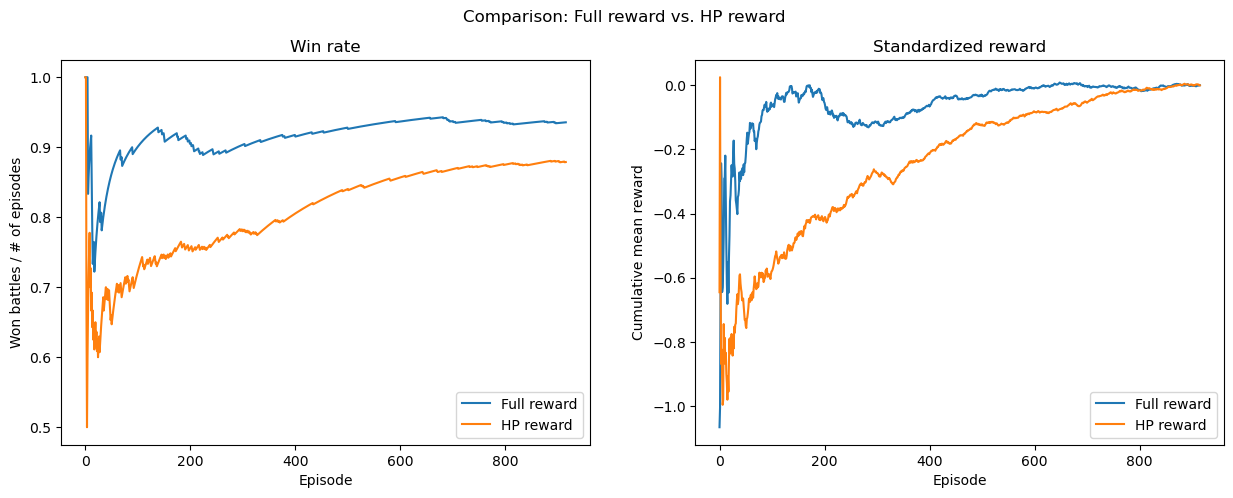

In [39]:
end = np.min(optimal_policy_episode)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Comparison: Full reward vs. HP reward')

ax1.plot(np.cumsum(won_battles[0,:end])/np.arange(1,end+1), label="Full reward")
ax1.plot(np.cumsum(won_battles[1,:end])/np.arange(1,end+1), label="HP reward")
ax1.set_title("Win rate")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Won battles / # of episodes")
ax1.legend(loc="lower right")

ax2.plot(np.cumsum((reward_history[0,:end] - np.mean(reward_history[0,:end]))/np.std(reward_history[0,:end]))/np.arange(1,end+1), label="Full reward")
ax2.plot(np.cumsum((reward_history[1,:end] - np.mean(reward_history[1,:end]))/np.std(reward_history[1,:end]))/np.arange(1,end+1), label="HP reward")
ax2.set_title("Standardized reward")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Cumulative mean reward")
ax2.legend(loc="lower right")

plt.show()

### Convergence

In [ ]:
n_episodes = 10000
convergence = np.zeros((2,1000))

optimal_policy_episode = [0,0]
epsilon = 0.15

for k in range(2):

    additional_reward = True if k == 0 else False
    
    for j in range(1000):
    
        env = gym.make("PokemonBattleEnv-v1",
                pokemon1=Pokemon(allowed_types=allowed_types).random_pkm(), 
                pokemon2=Pokemon(allowed_types=allowed_types).random_pkm(), 
                effectiveness_chart=effectiveness_chart,
                additional_reward=additional_reward,
                selftype_dmg=True)
        
        space_size = [space.n for space in env.observation_space.spaces]
        action_size = env.action_space.n
        
        QLearning = Qlearning_TDControl(space_size=space_size, action_size=action_size, gamma=1, lr_v=0.15)
        
        for i in range(n_episodes):
            done = False
            s = env.reset()
            a = QLearning.get_action_epsilon_greedy(s, epsilon)
            
            while not done:
                new_s, r, done, _ = env.step(a)
                new_a = QLearning.get_action_epsilon_greedy(new_s, epsilon)
                QLearning.single_step_update(s, a, r, new_s, done)
                a = new_a
                s = new_s
        
            if np.array_equal(QLearning.greedy_policy(), optimal_policy) and optimal_policy_episode[k] == 0:
                convergence[k,j] = i
                break
        
        if j % 100 == 0:
            print("Iteration: ", j)

In [36]:
np.mean(convergence, axis=1)

array([1187.443, 1275.87 ])

### Random vs Random perfect Opponent

- Random: randomly selects a move from the available moves
- Random perfect: selects a random move with 0.5 probability, otherwise select the move that is super effective against the opponent's type

In [31]:
n_episodes = 10000
reward_history = np.zeros((2,n_episodes))
won_battles = np.zeros((2,n_episodes))
Q_values = np.zeros((2,4,4,4))
optimal_policy_episode = [0,0]
epsilon = 0.15

for k in range(2):

    opponent = "random" if k == 0 else "random_perfect"
    
    env = gym.make("PokemonBattleEnv-v1",
               pokemon1=Pokemon(allowed_types=allowed_types).random_pkm(), 
               pokemon2=Pokemon(allowed_types=allowed_types).random_pkm(), 
               effectiveness_chart=effectiveness_chart,
               additional_reward=True,
               opponent=opponent,
               selftype_dmg=True)
    
    space_size = [space.n for space in env.observation_space.spaces]
    action_size = env.action_space.n
    
    QLearning = Qlearning_TDControl(space_size=space_size, action_size=action_size, gamma=1, lr_v=0.15)
    
    for i in range(n_episodes):
        done = False
        s = env.reset()
        a = QLearning.get_action_epsilon_greedy(s, epsilon)
        
        while not done:
            new_s, r, done, _ = env.step(a)
            new_a = QLearning.get_action_epsilon_greedy(new_s, epsilon)
            QLearning.single_step_update(s, a, r, new_s, done)
            a = new_a
            s = new_s
        
        reward_history[k,i] = env.reward
        won_battles[k,i] = 1 if env.pokemon2.is_fainted() else 0
        
        if np.array_equal(QLearning.greedy_policy(), optimal_policy) and optimal_policy_episode[k] == 0:
            Q_values[k] = QLearning.Qvalues
            optimal_policy_episode[k] = i
            print("Optimal policy found at episode: ", optimal_policy_episode[k])
            break
        
    if optimal_policy_episode[k] == 0:
        print("Optimal policy not found")
        optimal_policy_episode[k] = n_episodes

Optimal policy found at episode:  742
Optimal policy found at episode:  1275


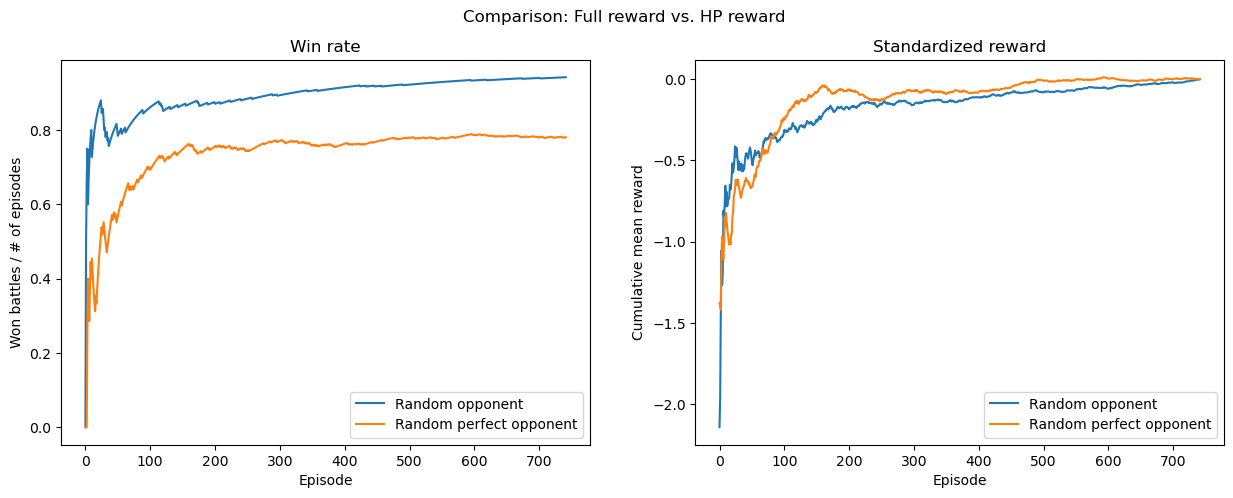

In [32]:
end = np.min(optimal_policy_episode)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Comparison: Full reward vs. HP reward')

ax1.plot(np.cumsum(won_battles[0,:end])/np.arange(1,end+1), label="Random opponent")
ax1.plot(np.cumsum(won_battles[1,:end])/np.arange(1,end+1), label="Random perfect opponent")
ax1.set_title("Win rate")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Won battles / # of episodes")
ax1.legend(loc='lower right')

ax2.plot(np.cumsum((reward_history[0,:end] - np.mean(reward_history[0,:end]))/np.std(reward_history[0,:end]))/np.arange(1,end+1), label="Random opponent")
ax2.plot(np.cumsum((reward_history[1,:end] - np.mean(reward_history[1,:end]))/np.std(reward_history[1,:end]))/np.arange(1,end+1), label="Random perfect opponent")
ax2.set_title("Standardized reward")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Cumulative mean reward")
ax2.legend(loc='lower right')

plt.show()

In [25]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n*factorial(n-1)
    
print(factorial(6)*6*6)

25920


# 6 types of pokemons

- 6 possible pokemon types: normal, fire, water, grass, fighting, flying
- each pokemon has 4 moves
- the first is the same as the pokemon type
- the other 3 are randomly selected from the ramaining 5 types

**Observation** = (pokemon type, opponent type, move2, move3, move4)

In [2]:
allowed_types = ['normal', 'fire', 'water', 'grass', 'fighting', 'flying']

effectiveness_chart = np.array([[1, 1, 1, 1, 1, 1],
                                [1, 1/2, 1/2, 2, 1, 1],
                                [1, 2, 1/2, 1/2, 1, 1],
                                [1, 1/2, 2, 1/2, 1, 1/2],
                                [2, 1, 1, 1, 1/2, 1/2],
                                [1, 1, 1, 2, 2, 1/2]])

In [4]:
env = gym.make("PokemonBattleEnv-v2",
               pokemon1=Pokemon(allowed_types=allowed_types).random_pkm(), 
               pokemon2=Pokemon(allowed_types=allowed_types).random_pkm(), 
               effectiveness_chart=effectiveness_chart,
               additional_reward=True,
               selftype_dmg=True)

In [ ]:
n_episodes = 50000
reward_history = np.zeros((2,n_episodes))
won_battles = np.zeros((2,n_episodes))
Q_values = np.zeros([2] + [len(allowed_types) for _ in range(env.observation_space.shape[0])] + [env.action_space.n])
optimal_policy_episode = [0,0]
epsilon = 0.4

for k in range(2):

    additional_reward = True if k == 0 else False
    
    env = gym.make("PokemonBattleEnv-v2",
               pokemon1=Pokemon(allowed_types=allowed_types).random_pkm(), 
               pokemon2=Pokemon(allowed_types=allowed_types).random_pkm(), 
               effectiveness_chart=effectiveness_chart,
               additional_reward=additional_reward,
               selftype_dmg=False)
    
    space_size = [len(allowed_types) for _ in range(env.observation_space.shape[0])]
    action_size = env.action_space.n
    
    QLearning = Qlearning_TDControl(space_size=space_size, action_size=action_size, gamma=1, lr_v=0.15)
    
    for i in range(n_episodes):
        done = False
        s = env.reset()
        a = QLearning.get_action_epsilon_greedy(s, epsilon)
        
        while not done:
            new_s, r, done, _ = env.step(a)
            new_a = QLearning.get_action_epsilon_greedy(new_s, epsilon)
            QLearning.single_step_update(s, a, r, new_s, done)
            a = new_a
            s = new_s
        
        reward_history[k,i] = env.reward
        won_battles[k,i] = 1 if env.pokemon2.is_fainted() else 0
        
        Q_values[k] = QLearning.Qvalues
        
        if i % 1000 == 0:
            print("Episode: ", i)

In [17]:
greedy_policy1 = np.argmax(Q_values[0], axis=-1)
greedy_policy2 = np.argmax(Q_values[1], axis=-1)

In [26]:
Q_values[0].shape

(6, 6, 6, 6, 6, 4)

In [19]:
print(greedy_policy1)
print()
print(greedy_policy2)

[[[[[0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 0 0 0]]

   [[0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 3 3 3]
    [0 0 1 0 3 2]
    [0 0 2 2 0 2]
    [0 0 0 1 3 0]]

   [[0 0 0 0 0 0]
    [0 0 0 0 1 1]
    [0 0 0 0 0 0]
    [0 1 0 0 2 3]
    [0 3 0 2 0 3]
    [0 3 0 1 3 0]]

   [[0 0 0 0 0 0]
    [0 0 1 0 3 0]
    [0 2 0 0 3 1]
    [0 0 0 0 0 0]
    [0 2 2 0 0 2]
    [0 0 2 0 2 0]]

   [[0 0 0 0 0 0]
    [0 0 1 1 0 1]
    [0 1 0 1 0 1]
    [0 3 3 0 0 2]
    [0 0 0 0 0 0]
    [0 1 1 1 0 0]]

   [[0 0 0 0 0 0]
    [0 0 3 2 3 0]
    [0 1 0 0 3 0]
    [0 1 3 0 1 0]
    [0 2 2 2 0 0]
    [0 0 0 0 0 0]]]


  [[[0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 0 0 0]]

   [[0 0 0 0 0 0]
    [0 0 0 0 0 0]
    [0 0 0 2 2 0]
    [0 0 3 0 3 0]
    [0 0 3 2 0 2]
    [0 0 3 2 0 0]]

   [[0 0 0 0 0 0]
    [0 0 0 1 1 1]
    [0 0 0 0 0 0]
    [0 1 0 0 1 1]
    [0 1 0 1 0 1]
    [0 1 0 1 1 0]]

   [[0 0

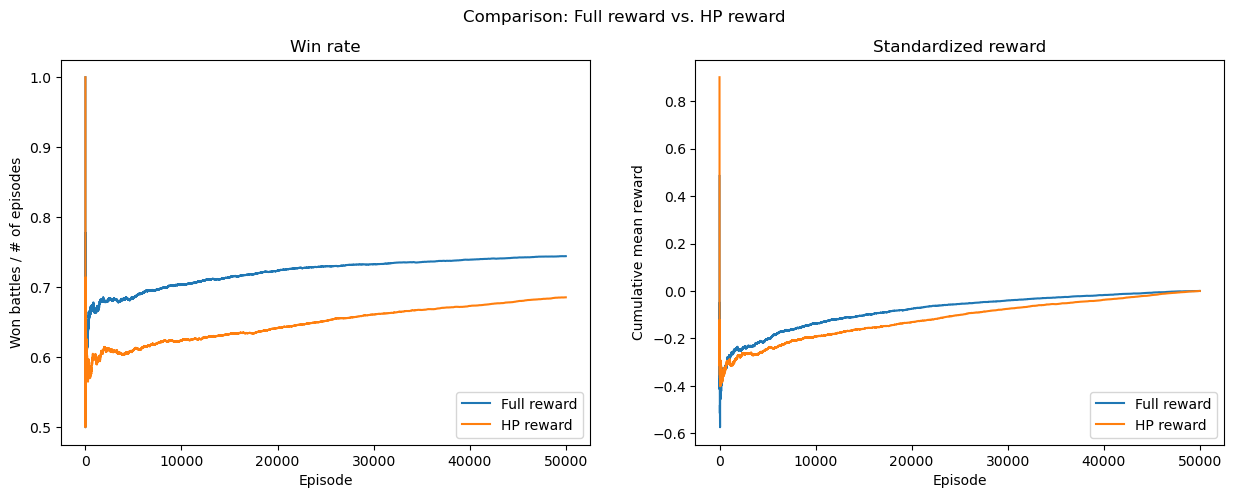

In [21]:
end = n_episodes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Comparison: Full reward vs. HP reward')

ax1.plot(np.cumsum(won_battles[0,:end])/np.arange(1,end+1), label="Full reward")
ax1.plot(np.cumsum(won_battles[1,:end])/np.arange(1,end+1), label="HP reward")
ax1.set_title("Win rate")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Won battles / # of episodes")
ax1.legend(loc="lower right")

ax2.plot(np.cumsum((reward_history[0,:end] - np.mean(reward_history[0,:end]))/np.std(reward_history[0,:end]))/np.arange(1,end+1), label="Full reward")
ax2.plot(np.cumsum((reward_history[1,:end] - np.mean(reward_history[1,:end]))/np.std(reward_history[1,:end]))/np.arange(1,end+1), label="HP reward")
ax2.set_title("Standardized reward")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Cumulative mean reward")
ax2.legend(loc="lower right")

plt.show()